In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
# plt.rcParams["animation.html"] = "html5"
from celluloid import Camera
from IPython.display import HTML

In [2]:
import json
import pickle
from random import sample
from pathlib import Path
import cv2
import numpy as np
import skimage.io as io
from PIL import Image
from IPython.display import display

In [3]:
img_root = Path('flatten_raw_images1024/train')
ps = list(img_root.glob('*.jpg'))
anns = json.load(open('df_face_anno_retinaRes50.json', 'r'))
splits = pickle.load(open('split_retina_face.pkl', 'rb'))
IDs = splits['train'] + splits['neg_landmarks'] + splits['closed_eyes']
print(len(ps), len(anns), len(IDs))

38480 38480 38480


* train: 可以使用的
* wrong_pos: y1 不在圖片上 1/3
* negs: landmarks 有負數
* no_face: 後來抽樣檢查抓到的
* dups: 兩個人，抽樣抓到的
* closed_eyes: 雙眼距離 / 左眼-鼻子距離 < 1/10

* 有些背對沒有臉的屬於 _additional
* 有些 _full 

In [13]:
def draw_landmarks(im, l, color=(255, 0, 0)):
    for x, y in l.astype(int).tolist():
        im = cv2.circle(im, (x, y), 3, color, -1)
    
    return im

def draw_box(im, b, color=(0, 255, 0)):
    x1, y1, x2, y2 = b.astype(int).tolist()
    return cv2.rectangle(im, (x1, y1), (x2, y2), color, 2)

In [12]:
def type1(im, l, b):
    canvas = Image.new('RGB', (768, 1152), color='white')
    canvas.paste(Image.fromarray(im), (10, 52))
    l = (l + np.array([[10, 52]])) / 3
    b = (b + np.array([10, 52, 10, 52])) / 3
    im = np.array(canvas.resize((256, 384), Image.LANCZOS))
    return im, l, b
    
def type2(im, l, b):
    canvas = Image.new('RGB', (256, 384), color='white')
    im = Image.fromarray(im).crop((56, 0, 696, 915)).resize((256, 366), Image.LANCZOS)
    canvas.paste(im, (0, 19))
    l = (l - np.array([[56, 0]])) / 2.5 + np.array([[0, 19]])
    b = (b - np.array([56, 0, 56, 0])) / 2.5 + np.array([0, 19, 0, 19])
    return np.array(canvas), l, b
    
def type3(im, l, b):
    return type1(im[:-1], l, b)

def type4(im, l, b):
    im = np.concatenate([im, np.full((1, im.shape[1], 3), 255).astype(np.uint8)], axis=0)
    return type1(im, l, b)

# def type5(im, l, b):

func_map = {
    (750, 1101): type1,
    (750,  915): type2,
    (750, 1102): type3,
    (750, 1100): type4,
#     (2574, 3861): type5,
}

def get_crop_square(l, ratio=2.0):   
    lm_eye_left = l[0]
    lm_eye_right = l[1]

    # Calculate auxiliary vectors.
    eye_left = l[0]
    eye_right = l[1]
    eye_avg = (eye_left + eye_right) * 0.5
    eye_to_eye = eye_right - eye_left
    mouth_left = l[3]
    mouth_right = l[4]
    mouth_avg = (mouth_left + mouth_right) * 0.5
    eye_to_mouth = mouth_avg - eye_avg

    # Choose oriented crop rectangle.
    x = eye_to_eye - np.flipud(eye_to_mouth) * [-1, 1]
    x /= np.hypot(*x)

    x *= max(np.hypot(*eye_to_eye) * ratio, np.hypot(*eye_to_mouth) * ratio * 0.9)
    y = np.flipud(x) * [-1, 1]
    c = eye_avg + eye_to_mouth * 0.3
    quad = np.stack([c - x - y, c - x + y, c + x + y, c + x - y])
    square = np.concatenate([quad.astype(int).min(axis=0, keepdims=True), quad.astype(int).max(axis=0, keepdims=True)], axis=0)

    return square

def get_align_parameters(im, l):
    assert isinstance(im, Image.Image)
    key = im.size
    assert key in [(750, 1102), (750, 1101), (750, 1100), (750, 915), (750, 1102), (2574, 3861)], key
    
    if key == (750, 1102):
        im = im.crop((0, 0, 750, 1101))
        
    if key == (750, 1100):
        im = Image.fromarray(np.concatenate([np.asarray(im), np.full((1, 750, 3), 255, dtype=np.uint8)], axis=0))
    
    if key in [(750, 1102), (750, 1101), (750, 1100)]:
        cw, ch, shrink, x_offset, y_offset = 768, 1152, 3, 10, 52
        canvas = Image.new('RGB', (cw, ch), color='white')
        canvas.paste(im, (x_offset, y_offset))
        l = (l + np.array([[x_offset, y_offset]]))
    elif key == (750, 915):
        cw, ch, shrink, x_offset, y_offset = 640, 960, 2.5, -56, 46
        canvas = Image.new('RGB', (cw, ch), color='white')
        im = im.crop((56, 0, 696, 915))
        canvas.paste(im, (0, 46))
        l = (l + np.array([[-56, 46]]))
    elif key == (2574, 3861):
        cw, ch, shrink = 2560, 3840, 10
        canvas = im.crop((8, 0, 2568, 3840))
        l = (l + np.array([[-8, 0]]))
    else:
        raise ValueError("Unsupported raw image size")
        
    return canvas, l, cw, ch, shrink, 

In [ ]:
Image.open(img_root / f'id_00007942_01_1_front.jpg')

In [5]:
wh = {}
for ID in IDs:
    im = Image.open(img_root / f'{ID}.jpg')
    if im.size not in wh:
        wh[im.size] = 0
        print(f"{im.size}: {ID}")
    wh[im.size] += 1
wh

(750, 1101): id_00000001_02_1_front
(750, 915): id_00000961_03_1_front
(2574, 3861): id_00002768_02_1_front
(750, 1102): id_00005702_08_2_side
(750, 1100): id_00007942_01_1_front


{(750, 1101): 38375,
 (750, 915): 102,
 (2574, 3861): 1,
 (750, 1102): 1,
 (750, 1100): 1}

In [5]:
shape = {}
for ID in splits['train']:
    im = Image.open(img_root / f'{ID}.jpg')
    shape.setdefault(im.size, []).append(ID)
{k: len(v) for k, v in shape.items()}

{(750, 1101): 31590, (750, 915): 89, (2574, 3861): 1, (750, 1102): 1}

In [13]:
# KEY = (750, 1101) #(750, 915)
# sample_IDs = sample(shape[KEY], 12)
RES = 256
Y1 = 0
RATIOS = np.arange(1, 0.1, -0.05).tolist()
img_list = []
for ID in ['id_00000001_02_1_front', 'id_00000961_03_1_front', 'id_00002768_02_1_front', 'id_00005702_08_2_side', 'id_00007942_01_1_front']: # sample_IDs:
    im = Image.open(img_root / f'{ID}.jpg')
    ann = anns[ID]
    key = im.size
    l = np.array(ann['landmarks'])
    b = np.array(ann['box'])
    # im, l, b = func_map[key](np.array(im), l, b)
    
    # plot
    #fig, ax = plt.subplots()
    #camera = Camera(fig)

    im, l, cw, ch, shrink = get_align_parameters(im, l)
    square = get_crop_square(l, ratio=1.0)
    src = np.array([tuple(square[0]), (square[0, 0], square[1, 1]), tuple(square[1])], dtype=np.float32)
    
    ims = []
    for ratio in RATIOS:
        dst = np.array([(int(cw / 2 - (cw * ratio / 2)), Y1),
                        (int(cw / 2 - (cw * ratio / 2)), int(Y1 + cw * ratio)),
                        (int(cw / 2 + (cw * ratio / 2)), int(Y1 + cw * ratio))], np.float32)

        M = cv2.getAffineTransform(src, dst)
        trans_im = cv2.warpAffine(np.array(im), M, (cw, ch), flags=cv2.INTER_LANCZOS4, borderValue=(255, 255, 255))
        trans_im = cv2.resize(trans_im, (int(cw // shrink), int(ch // shrink)), interpolation=cv2.INTER_LANCZOS4)
        ims.append(trans_im)
        # ax.imshow(trans_im)
        # ax.set_axis_off()
        # camera.snap()
    
    img_list.append(ims)
    # animation = camera.animate() # animation ready
    # HTML(animation.to_html5_video())
    # animation.save(f'zoom_out_{ID}.mp4')
    # ims = np.array(ims)
    # ims = ims.reshape(1, len(RATIOS), th, tw, 3).swapaxes(1, 2).reshape(1 * th, len(RATIOS) * tw, 3)
    # display(Image.fromarray(ims))

### Zoom out animation - Grid

In [16]:
for ims in img_list:
    for im in ims:
        if im.shape != (384, 256, 3):
            print(im.shape)

In [17]:
ROW, COL = 1, 5
fig, ax = plt.subplots()
camera = Camera(fig)
for t in range(len(img_list[0])):
    ims = []
    for i in range(len(img_list)):
        ims.append(img_list[i][t])
    ims = np.array(ims)
    ims = ims.reshape(ROW, COL, 384, 256, 3).swapaxes(1, 2).reshape(ROW*384, COL*256, 3)
    ax.imshow(ims)
    ax.set_axis_off()
    camera.snap()
animation = camera.animate()
HTML(animation.to_html5_video())
# animation.save('examples/zoom_out.mp4')

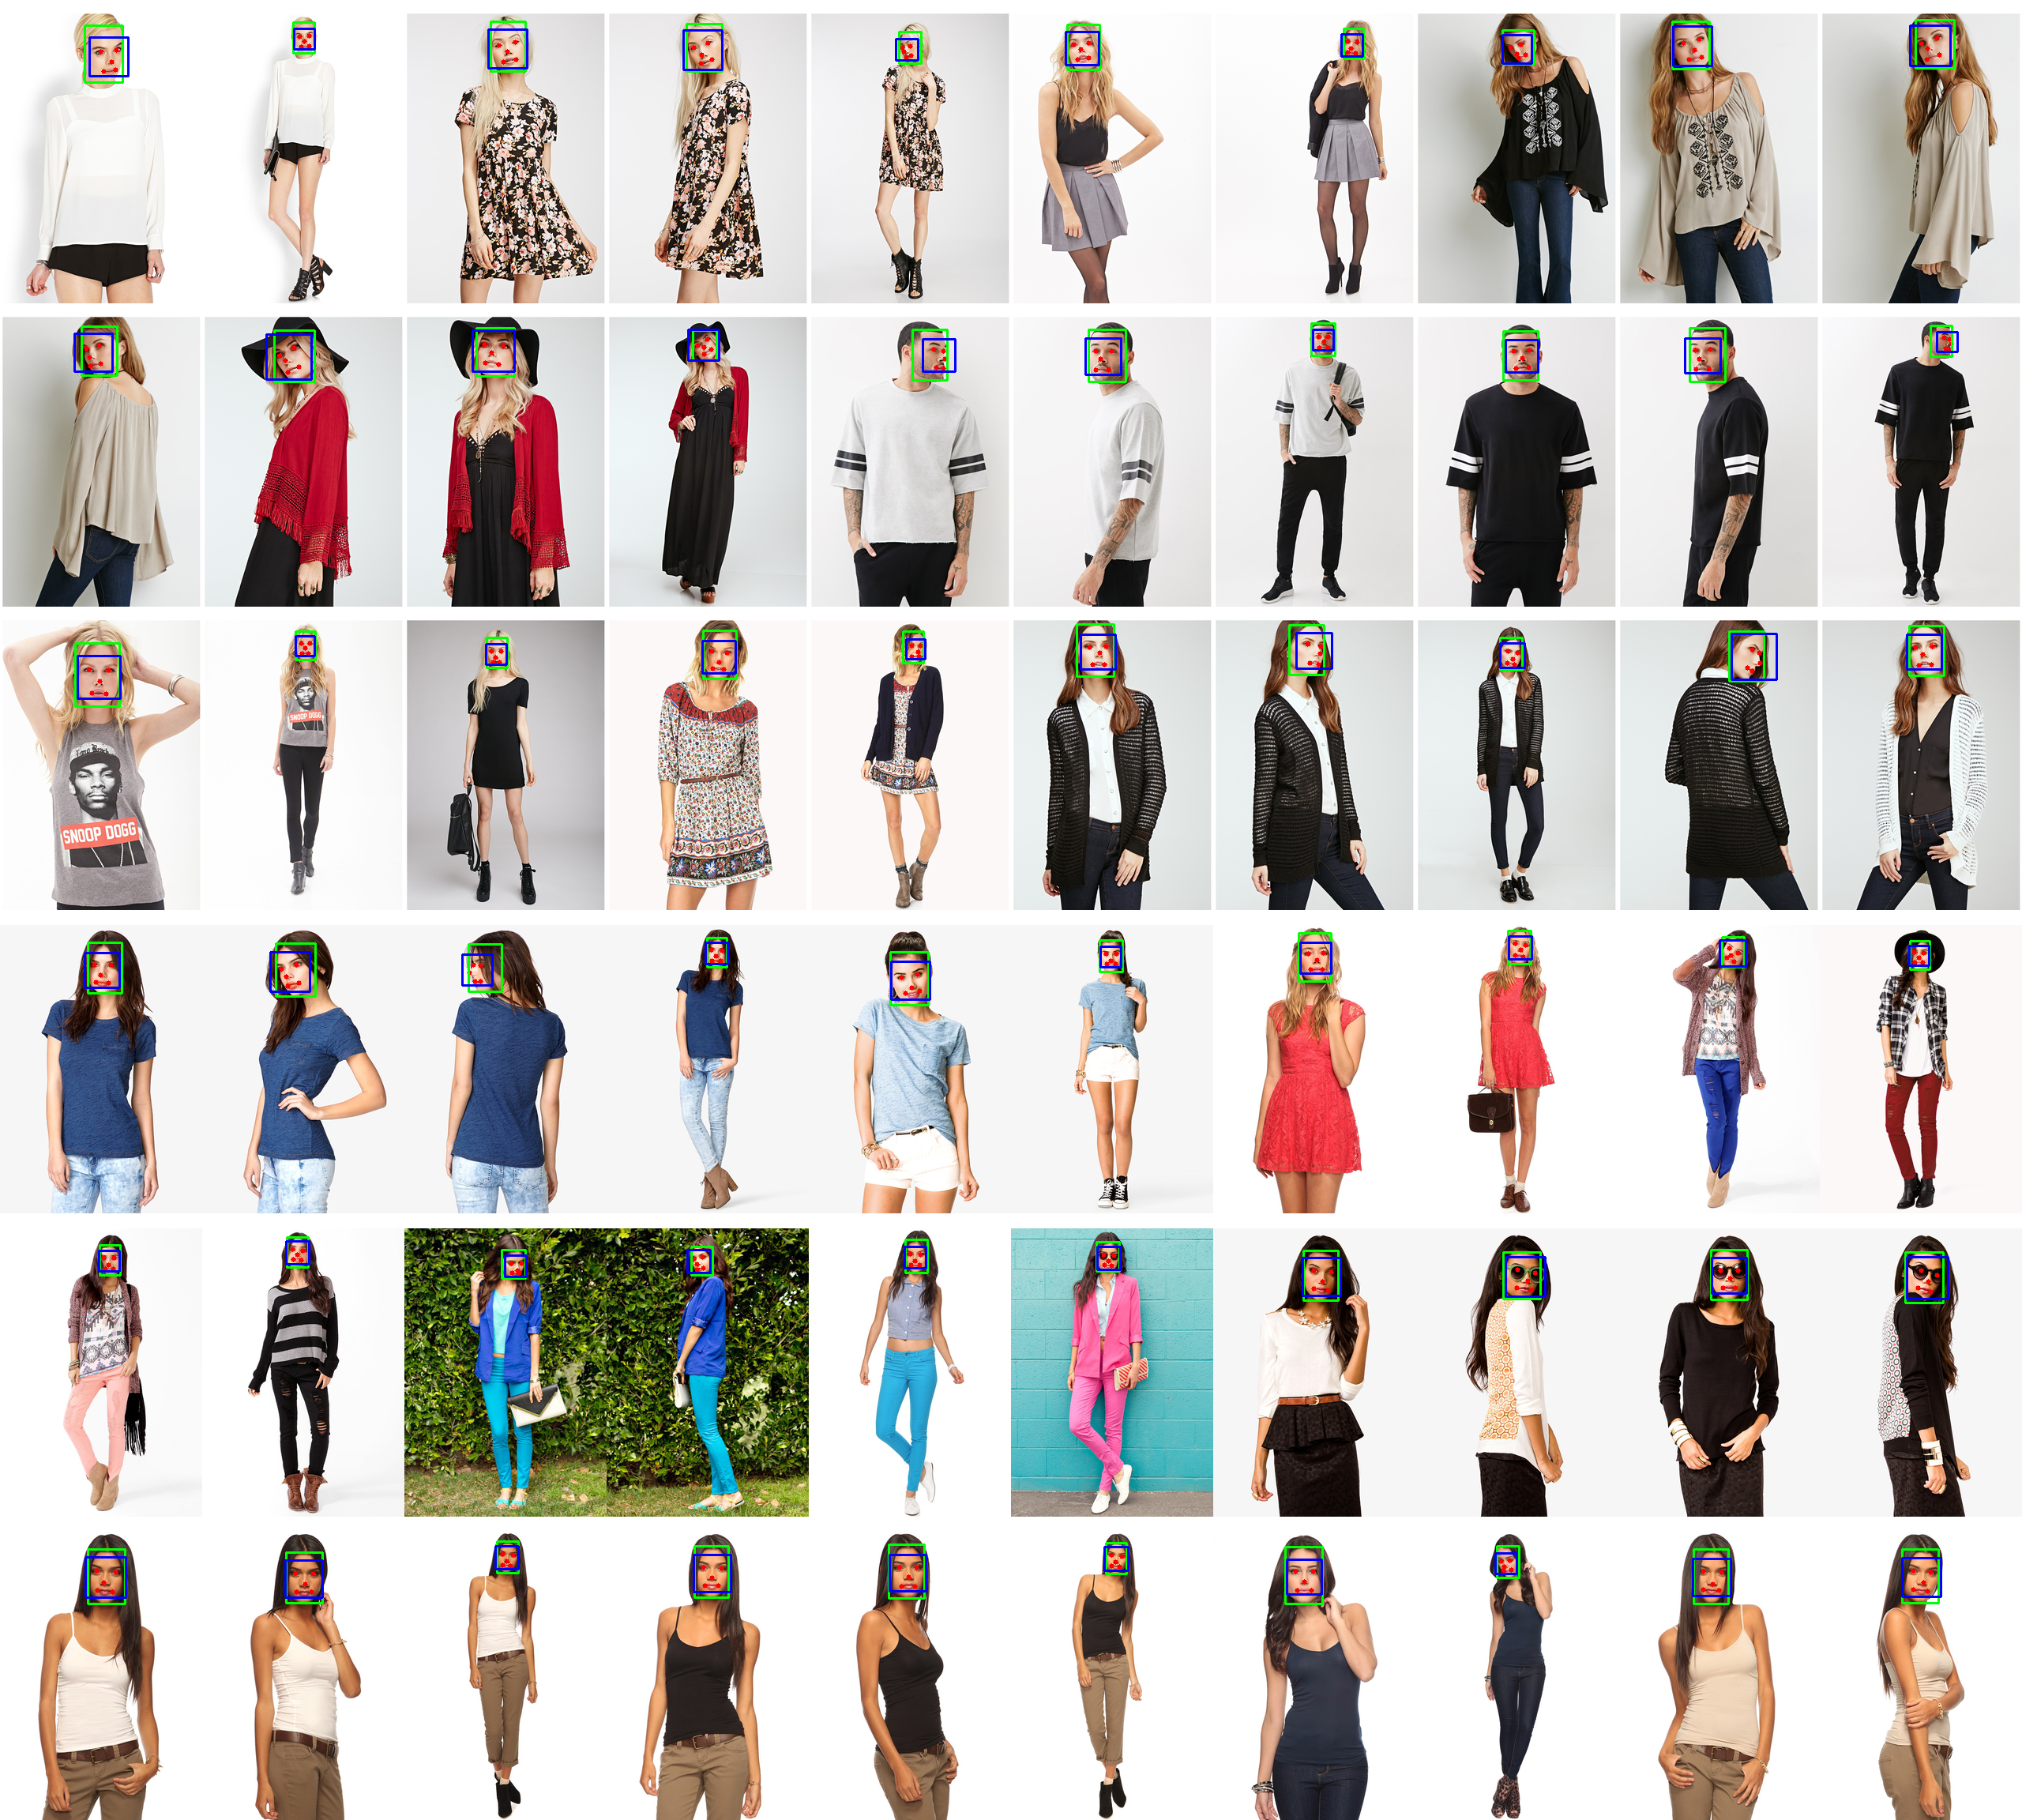

In [333]:
ims = {(750, 1101): [], (750, 915): []}
i = 0
for ID in IDs:
    print(i, end='\r')
    i+=1
    if all([len(_) == 30 for _ in ims.values()]):
        break
    
    im = Image.open(img_root / f'{ID}.jpg')
    key = im.size
    if key not in ims or len(ims[key]) == 30:
        continue
    
    ann = anns[ID]
    l, b = np.array(ann['landmarks']), np.array(ann['box'])
    im, l, b = func_map[key](np.asarray(im), l, b)
    square = get_crop_square(l, ratio=1.0).astype(int).flatten()
    im = draw_landmarks(im, l)
    im = draw_box(im, b)
    im = draw_box(im, square, color=(0, 0, 255))
    
    ims[key].append(im)

ims = np.array(ims[(750, 1101)] + ims[(750, 915)])
ims = ims.reshape(6, 10, 384, 256, 3).swapaxes(1,2).reshape(6*384, 10*256, 3)
display(Image.fromarray(ims))

In [ ]:
Image.open(img_root / f'{IDs[21]}.jpg')